# Data Modelling - Determining AWS S3 Storage Tier

Use the syenthetic data to build model(s) that predicits the storage tier of new files. 
To efficiently and correctly catergorize files into different storage tiers is useful becuase it allows for cost optimization, storage efficiency, and client performance optimization: retrivel times 

## AWS S3 Tiers 

The model(s) built will analyze the metadata of the file to store it in one of three storage classes

Overview of the storage classses in use: 

<table align="left" style="width:50%"> 
    <tr>
        <th>Class</th>
        <th>Use Case</th>
        <th>Tier</th> 
    </tr>
    <tr>
        <td>S3 Standard</td>
        <td>Frequently Accessed</td>
        <td>"Hot"</td>
    </tr>
    <tr>
        <td>S3 One Zone-IA</td>
        <td>Infrequent, low-availability data </td>
        <td>"Warm"</td>
    </tr>
    <tr>
        <td>S3 Glacier (Deep Archieve?)</td>
        <td>Rarely Accessed / Long-term rarely accessed</td>
        <td>"Cold"</td>
    </tr>
</table> 
 

## Step 1) Data Preperation - preprocessing


Possible approaches towards a dataset preprocessing before fitting it a model 

**1)** Handle missing/null values 

**2)** Normalize/scale numerical features 

Standardization: Scale values to have a mean of 0 and standard deviation of 1.

Normalization: Rescale values to fall within a range (e.g., 0–1).

**3)** Encode categorical features : ordinal encoding ( hot > warm > cold)

**4)** Feature engineering + Class imbalance ( create/remove columns ) 

New rows for edge cases to help the model learn critical boundries,

Talk about not dropping access_frequency and frequency of access.  

need to determine if the target variable 'Storage_Tier' in the dataset is balanced, risk the model becoming biased  


#### Handling missing/null values

In [150]:
import numpy as np 
import pandas as pd 

np.random.seed(1)  

df = pd.read_csv("../../data/train-model/train-file-metadata.csv") 

df.head(n=10) 


,File_ID,Access_Frequency,Frequnecy_of_Access,File_Size,File_Lifecycle_Stage,Modification_Frequency,File_Age,Storage_Tier
0,File_1,21.2307,24.4205,0.0000,0.0000,23.3177,2.6015,Hot
1,File_2,24.0589,4.5884,1.8784,8.4383,4.8516,7.7843,Warm
2,File_3,25.1752,10.1110,0.0000,0.0000,5.7295,1.9126,Warm
3,File_4,4.2926,17.4557,0.0000,0.0000,8.7832,2.3784,Cold
4,File_5,19.9357,23.3908,0.0000,0.0000,12.2302,3.5120,Warm
5,File_6,28.4249,23.1148,7.0560,9.1548,9.2075,1.8900,Hot
6,File_7,19.6673,8.6535,6.2278,7.9220,14.8424,0.0000,Warm
7,File_8,16.5561,22.7516,4.0345,3.5290,9.6637,5.4443,Warm
8,File_9,9.0017,8.5943,15.8221,15.2384,9.1963,0.0000,Warm
9,File_10,17.6529,18.1427,10.5044,4.3349,4.9068,5.5250,Warm


In [151]:
print(df.info())
print(df["Storage_Tier"].unique())
print(df.shape) 


df.isna().sum() # shows that there is a complete dataset no missing or null values 
df.describe() #  column values needs to be normalized for better model fit

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   File_ID                 2000 non-null   object 
 1   Access_Frequency        2000 non-null   float64
 2   Frequnecy_of_Access     2000 non-null   float64
 3   File_Size               2000 non-null   float64
 4   File_Lifecycle_Stage    2000 non-null   float64
 5   Modification_Frequency  2000 non-null   float64
 6   File_Age                2000 non-null   float64
 7   Storage_Tier            2000 non-null   object 
dtypes: float64(6), object(2)
memory usage: 125.1+ KB
None
['Hot' 'Warm' 'Cold']
(2000, 8)


,Access_Frequency,Frequnecy_of_Access,File_Size,File_Lifecycle_Stage,Modification_Frequency,File_Age
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,15.515501,12.030583,7.976287,5.460082,10.834073,2.669299
std,8.291801,7.569856,8.205440,5.579764,6.968456,2.702448
min,2.077500,1.007200,0.000000,0.000000,1.013700,0.000000
25%,8.705800,5.658150,0.000000,0.000000,5.471100,0.000000
50%,14.539200,9.676650,6.135600,4.304750,8.902350,2.147300
75%,21.577300,18.057800,13.035925,8.843775,15.534425,4.273350
max,34.595800,29.673700,29.696700,19.798900,29.658500,9.889600


the description of the dataset shows that the values need to be standardized for all the columns to have a mean of 0 and a standard deviation of 1. also shows evidence for normalizatoin so will need to resacle values to fall under the range 0 - 1

the dataset is complete, no handling of missing values that have to be imputed by the mean of certain columns 

#### Normalize & Standardize columns

why is it important to standardize and normalize the values? 

standardize helps avoid the features that have larger values from dominating the model and developing a bias and helps bring the values closer to a normal distribution ( i will use visualization tools to check if this is true - seaborn? ). normalizing helps all the features be scaled to the same range most commonly 0 - 1 


In [152]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler 


stand__norm_columns = df.select_dtypes(include=['float64']).columns

scaler_standard = StandardScaler() 
scaler_minmaxScaler = MinMaxScaler() 

df_copy = df.copy() 

#Standardize
standardized_value = scaler_standard.fit_transform(df[stand__norm_columns])
for row, col in enumerate(stand__norm_columns): 
    df_copy[f"{col}"] = standardized_value[:, row ]

 
#Normalzie 
normalized_values = scaler_minmaxScaler.fit_transform(df[stand__norm_columns])
for row, col in enumerate(stand__norm_columns): 
    df_copy[f"{col}"] = normalized_values[:, row]

df_copy = df_copy.round(4) # higher precision for imporved accuracy 

np.random.seed(2) 

output_file = "preprocessed-train-file-metadata.csv" 
df_copy.to_csv(output_file, index=False)



now, use the 'preprocessed-train-file-metadata.csv' for further preprocessing

#### Encode Categorical Features


In [153]:
df = pd.read_csv("preprocessed-train-file-metadata.csv") 

df.head(n=5)

df.columns.unique() 

print(df["Storage_Tier"].dtype)  

tier_mapping = { "Hot" : 2 , "Warm" : 1 , "Cold" : 0 }

df["Storage_Tier_Encoded"] = df["Storage_Tier"].map(tier_mapping) 
output_file = ("preprocessed-train-file-metadata.csv" )
df.to_csv(output_file, index=False) 

print(df.head(n=3))

print(df["Storage_Tier_Encoded"].dtype)


object
  File_ID  Access_Frequency  Frequnecy_of_Access  File_Size  \
0  File_1            0.5890               0.8167     0.0000   
1  File_2            0.6760               0.1249     0.0633   
2  File_3            0.7103               0.3176     0.0000   

   File_Lifecycle_Stage  Modification_Frequency  File_Age Storage_Tier  \
0                0.0000                  0.7786    0.2631          Hot   
1                0.4262                  0.1340    0.7871         Warm   
2                0.0000                  0.1646    0.1934         Warm   

   Storage_Tier_Encoded  
0                     2  
1                     1  
2                     1  
int64


used ordinal coding becuase the value of storage tier does matter to train the model

hot > warm > cold 

2 > 1 > 0 

#### Feature Engineering & Class Imbalance 

will drop the storage tier  string column , obvious reason 

try to deteremine if the target variable : " storage_tier_encoded " normal distribution, check for tight edge cases that will imporve the model for boundary cases: if this is lacking then will manually add more rows 

check if there is a class imbalance for the storage tier to avoid the model overfitting on a certain tier and having a bias. 

In [162]:
df = df.drop("Storage_Tier", axis=1)  

find z-score to deteremine if a row is an outlier, this test is usually run on columns for which the values are continouns. check for z-score for access_frequency 
z  = x - mean / standard_deviation 

In [163]:
mean = df["Access_Frequency"].mean() 
stand_deviation = df["Access_Frequency"].std() 

df["Z_Score_Access_Frequency"] = round((df["Access_Frequency"] - mean ) / stand_deviation , 4 ) 

outliers = df[abs(df["Z_Score_Access_Frequency"]) > 3 ] 
outliers

,Access_Frequency,Frequnecy_of_Access,File_Size,File_Lifecycle_Stage,Modification_Frequency,File_Age,Storage_Tier_Encoded,Z_Score_Access_Frequency


check for class imblanace 

Text(0, 0.5, 'Number of training rows')

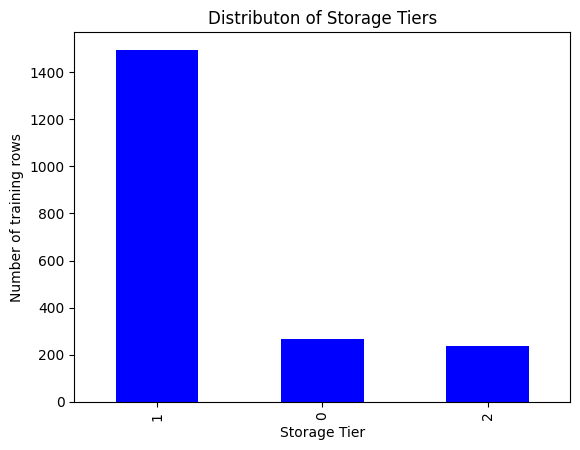

In [164]:
import matplotlib.pyplot as plt 

col_count = df["Storage_Tier_Encoded"].value_counts() 

col_count.plot(kind='bar', color = 'blue')
plt.title("Distributon of Storage Tiers") 
plt.xlabel("Storage Tier") 
plt.ylabel("Number of training rows") 

clearly, the target column is heavely skewed in the favour the warm storage (1) 

In [165]:
class_counts = df["Storage_Tier_Encoded"].value_counts() 
print(class_counts)

class_percentage = df["Storage_Tier_Encoded"].value_counts(normalize=True)  * 100 
print(class_percentage)

Storage_Tier_Encoded
1    1495
0     266
2     239
Name: count, dtype: int64
Storage_Tier_Encoded
1    74.75
0    13.30
2    11.95
Name: proportion, dtype: float64


will use SMOTE (synthetic minority over-sampling technique) before training the models, to handle the class imbalance by generating synthetic samples for the minority classes  

## Step 2) Baseline Model 

In [193]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression # multinomal 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score

from imblearn.over_sampling import SMOTE 

from xgboost import XGBClassifier 

from collections import Counter 

import ipywidgets as widgets 

In [182]:
# df = df.drop('File_ID',axis = 1) 

In [183]:

print(df.head(n=5))
X = df.drop('Storage_Tier_Encoded', axis = 1)
Y = df["Storage_Tier_Encoded"] 

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,train_size=0.8, test_size = 0.2) 

smote = SMOTE(random_state=42)
X_train_SMOTE,Y_train_SMOTE = smote.fit_resample(X_train, Y_train) 

print(Counter(Y_train))
print(Counter(Y_train_SMOTE)) 
np.random.seed(42)  
print("Training examples: {}".format(X_train_SMOTE.shape[0])) 
print("Training labels: {}".format(Y_train_SMOTE.shape[0])) 
print("Test examples:{}".format(X_test.shape[0]) )

   Access_Frequency  Frequnecy_of_Access  File_Size  File_Lifecycle_Stage  \
0            0.5890               0.8167     0.0000                0.0000   
1            0.6760               0.1249     0.0633                0.4262   
2            0.7103               0.3176     0.0000                0.0000   
3            0.0681               0.5738     0.0000                0.0000   
4            0.5492               0.7808     0.0000                0.0000   

   Modification_Frequency  File_Age  Storage_Tier_Encoded  \
0                  0.7786    0.2631                     2   
1                  0.1340    0.7871                     1   
2                  0.1646    0.1934                     1   
3                  0.2712    0.2405                     0   
4                  0.3916    0.3551                     1   

   Z_Score_Access_Frequency  
0                    0.6893  
1                    1.0305  
2                    1.1650  
3                   -1.3536  
4                   

now the training data is balanced and thus should avoid and bias 

#### Logisitc Regresion Model 

In [184]:
multinomail_LR_model = LogisticRegression(multi_class='multinomial')
multinomail_LR_model.fit(X_train_SMOTE, Y_train_SMOTE) 

LogisticRegression(multi_class='multinomial')

In [217]:

predict = multinomail_LR_model.predict(X_test) 
multi_LR_model_accuracy = accuracy_score(Y_test, predict) * 100 

print(f"Accuracy Score of the Multinomal Logisitric Regression Model: {multi_LR_model_accuracy}%")
# f1_score_LR_model = round(f1_score(Y_test, predict, average='weighted'),4) * 100

# print(f"The F1-Score is {f1_score_LR_model}%") 

# print("\nConfusion Matrix", confusion_matrix(Y_test, predict)) 
print("Classification Report for Multinomail Logistic Regression model:\n ", classification_report(Y_test, predict)) 


Accuracy Score of the Multinomal Logisitric Regression Model: 87.5%
Classification Report for Multinomail Logistic Regression model:
                precision    recall  f1-score   support

           0       0.66      1.00      0.79        52
           1       1.00      0.83      0.91       303
           2       0.66      1.00      0.80        45

    accuracy                           0.88       400
   macro avg       0.77      0.94      0.83       400
weighted avg       0.92      0.88      0.88       400



Despite the multinomal logistic regression model preforming really well, I will try to train some other models like KNN, Decision Tree, Random Forrest, and a Gradient Boosting Model because each of them bring their own strengths for a classification task. At the end, I can summarize the models to deteremine which one worked the best given the dataset and then deploy that model as RESTAPI. 

## Step 3) Model Training and Evaluation

#### K-nearest neighbors (KNN) Model

In [199]:
knn_model = KNeighborsClassifier(n_neighbors = 5) 
knn_model.fit(X_train_SMOTE, Y_train_SMOTE) 

KNeighborsClassifier()

In [216]:
predict = knn_model.predict(X_test) 
accuracy = accuracy_score(Y_test, predict) * 100 
class_report = classification_report(Y_test,predict) 

print(f"Accuracy of KNN model: {accuracy}%") 
print(f"Classification Report of KNN model:\n {class_report}")

Accuracy of KNN model: 84.25%
Classification Report of KNN model:
               precision    recall  f1-score   support

           0       0.64      0.94      0.76        52
           1       0.98      0.81      0.89       303
           2       0.59      0.98      0.73        45

    accuracy                           0.84       400
   macro avg       0.74      0.91      0.79       400
weighted avg       0.89      0.84      0.85       400



#### Decision Tree Model

In [208]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train_SMOTE, Y_train_SMOTE) 

DecisionTreeClassifier()

In [218]:
predict = tree_model.predict(X_test) 
accuracy = accuracy_score(Y_test, predict) * 100 
class_report = classification_report(Y_test, predict)

print(f"Accuracy of Decision Tree Model: {accuracy}%")
print(f"Classification Report of Decision Tree Model:\n {class_report}") 

Accuracy of Decision Tree Model: 86.5%
Classification Report of Decision Tree Model:
               precision    recall  f1-score   support

           0       0.76      0.81      0.79        52
           1       0.93      0.89      0.91       303
           2       0.62      0.78      0.69        45

    accuracy                           0.86       400
   macro avg       0.77      0.82      0.80       400
weighted avg       0.87      0.86      0.87       400



#### Random Forest Model

In [271]:
Rforest_model = RandomForestClassifier(n_estimators=100) 
Rforest_model.fit(X_train_SMOTE,Y_train_SMOTE) 

RandomForestClassifier()

In [272]:
predict = Rforest_model.predict(X_test) 
accuracy = accuracy_score(Y_test, predict) * 100 

class_report = classification_report(Y_test, predict) 

print(f"Accuract Score of Random Forrest Model: {accuracy}%") 
print(f"Classification Report of Random Forrest Molde:\n {class_report}") 

Accuract Score of Random Forrest Model: 90.25%
Classification Report of Random Forrest Molde:
               precision    recall  f1-score   support

           0       0.79      0.81      0.80        52
           1       0.94      0.93      0.94       303
           2       0.78      0.84      0.81        45

    accuracy                           0.90       400
   macro avg       0.84      0.86      0.85       400
weighted avg       0.90      0.90      0.90       400



#### XGBoost Model

In [268]:
xgboost_model = XGBClassifier(eval_metric = 'mlogloss', random_state= 42) 
xgboost_model.fit(X_train_SMOTE, Y_train_SMOTE) 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [269]:
predict = xgboost_model.predict(X_test) 
accuracy = accuracy_score(Y_test, predict) * 100 
class_report = classification_report(Y_test, predict) 

print(f"Accuracy Score XGBoost Model: {accuracy}%") 
print(f"Classification Report XGBoost Model: \n {class_report}") 

Accuracy Score XGBoost Model: 92.5%
Classification Report XGBoost Model: 
               precision    recall  f1-score   support

           0       0.88      0.83      0.85        52
           1       0.96      0.94      0.95       303
           2       0.78      0.93      0.85        45

    accuracy                           0.93       400
   macro avg       0.87      0.90      0.88       400
weighted avg       0.93      0.93      0.93       400



<h3>Summary of Basic Models</h3>

<br>

<table align="left">
    <tr>
        <th>Model Type</th>
        <th>Accuracy</th>
        <th> Weighted F1-Score Avg</th>
    </tr>
    <tr>
        <td>Logistic Regression</td>
        <td>87.5%</td>
        <td>0.88</td>
    </tr>
    <tr>
        <td>K-nearest neighbors </td>
        <td>84.25%</td>
        <td>0.85</td>
    </tr>
    <tr>
        <td>Decision Tree</td>
        <td>86.5%</td>
        <td>0.87</td>
    </tr>
    <tr>
        <td>Random Forest</td>
        <td>91.0%</td>
        <td>0.91</td>
    </tr>
    <tr>
        <td>XGBoost</td>
        <td>92.5%</td>
        <td>0.93</td>
    </tr>
</table>

<br>

why did random forest and XGBoost work so well on this dataset? 

Random Forest uses multiple decision trees ( so it make sense why it outperformed deciion tree) and then averages out the predictions of the trees to avoid overfitting, and in addtion to using SMOTE for the class imbalance random forest inherenrlty balances the majority and minority classes. 

All in all both methods are ensemble learning models, and the fact that the logisitc regression and decision tree model have strong accuracy score it makes intutitve sense that the models that use it as weak learners creative a stronger overall model. 

#### Neural Network? 

## Step 4) Model Deployment 

since the XGBoost model has the most accurate model and the closest weighted f1_score avg to 1, it is safe to use this model to classify the storage tier of new files that follow the same csv/json? schema as the datset used to train the model. 

#### Save the trained model

In [274]:
import pickle 

with open("../xgboost-model/xgboost_model.pkl","wb") as file: 
    pickle.dump(xgboost_model, file)